In [113]:
from collections import Counter, defaultdict, OrderedDict
import json
from statsmodels.stats.inter_rater import fleiss_kappa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline  


In [311]:
class SimpleNamespace (object):
    def __init__ (self, **kwargs):
        self.__dict__.update(kwargs)
    def __repr__ (self):
        keys = sorted(self.__dict__)
        items = ("{}={!r}".format(k, self.__dict__[k]) for k in keys)
        return "{}({})".format(type(self).__name__, ", ".join(items))
    def __eq__ (self, other):
        return self.__dict__ == other.__dict__

__ds = SimpleNamespace()

    
def get_file(file_id):
    return "/home/haowu4/codes/finer-annotation-web/analysis/gold_docs/%s.json" % (file_id[2:].replace("/", "-"))

def load_example_list(type_name):    
    captured = []
    
    for instance_, tc in annotations_per_instance.iteritems():
        if tc[type_name] > 0:
            did, sid, start, end = instance_.split("-")
            captured.append((did, int(sid), int(start), int(end)))
    
    return captured



def load_text(example):
#     print example
    did, sid, start, end = example
    with open(get_file(did)) as j_in:
        doc = json.load(j_in)
    sent = doc['sentences'][sid]
    ret = ['<p style="font-size: 20px !important;">']
    for i, t in enumerate(sent["tokens"]):
        if i == start:
            ret.append('<b style="color: #ff0000;">')
        ret.append(t)
        if i == end-1:
            ret.append("</b>")
    ret.append("</p>")
    return " ".join(ret)


def kao_of_type(typ):
    mat = []
    p_items = []
    
    for mention_id, anno in annotations_per_instance.iteritems():
        total_count = anno[TOTAL_]
        if total_count != 2:
            continue
        total_count = float(total_count)
        yes_count = anno[typ]
        no_count = total_count - yes_count
        yes_count = float(yes_count)
        no_count = float(no_count)
        mat.append([yes_count, no_count])
        
        pi = (1/(total_count * (total_count - 1)))
        
    return fleiss_kappa(np.matrix(mat))

In [69]:
with open("/home/haowu4/codes/finer-annotation-web/analysis/dump1.json") as _:
    data = json.load(_)

In [79]:
type_counter = Counter()
feedbacks = []

annotations = defaultdict(list)
annotations_per_instance = defaultdict(Counter)

TOTAL_ = "TOTAL"

for annotation in data:
    ans = annotation["answer"]
    vs = json.loads(ans)
    
    fb = vs["feedBackText"]
    if len(fb) > 0:
        feedbacks.append(fb)
    del vs["feedBackText"]
    

    
    for k, v in vs.iteritems():
        type_counter.update(v.split("-"))
        if annotations_per_instance[k][TOTAL_] < 2:
            annotations_per_instance[k].update(v.split("-") + [TOTAL_])
        annotations[k].append(v)
        
example_size = {k:len(load_example_list(k)) for k in type_counter}

In [80]:
annotations_per_instance["./nw/wsj/15/wsj_1565.v4_gold_conll-3-21-22"]

Counter({'TOTAL': 2,
         u'location': 1,
         u'location.city': 1,
         u'person': 1,
         u'person.politician': 1,
         u'person.soldier': 1})

In [93]:
aggs = {k:kao_of_type(k) for k in type_counter if len(k) > 0}

type_tao_count = []
for rank, (t, tao) in enumerate(type_counter.most_common()):
    if len(t) == 0:
        continue
    d = OrderedDict([
            ("label", t),
            ("tao", aggs[t]),
            ("count", type_counter[t]),
            ("freq_rank", rank)
        ])
    
    type_tao_count.append(d)

In [125]:
# def print_full(x):
#     pd.set_option('display.max_rows', len(x))    
#     pd.reset_option('display.max_rows')
#     return x
pd.options.display.max_rows = 999
df = pd.DataFrame.from_dict(type_tao_count)

# print_full(df)
df.sort(["tao", "count"], ascending=[False, True]).reset_index(drop=True)


/home/haowu4/anaconda3/envs/dataless_finer/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,label,tao,count,freq_rank
0,building.hotel,1.000000,2,75
1,person.religious_leader,1.000000,2,76
2,person.athlete,1.000000,12,41
3,finance.currency,0.891487,727,7
4,event.natural_disaster,0.888793,9,43
5,medicine.drug,0.857047,7,50
6,location,0.855044,1981,2
7,time,0.827059,1405,4
8,person.doctor,0.817796,22,32
9,person,0.788717,1214,5


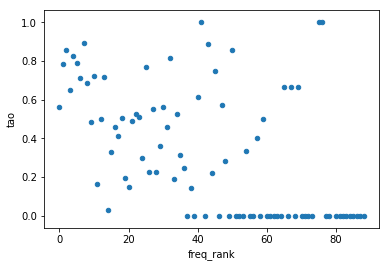

In [126]:
df.plot(kind="scatter", x="freq_rank", y = "tao")

In [309]:
from ipywidgets import widgets, interact
from IPython.display import display

"""
    Defining widgets
"""
_doc_selection = widgets.IntSlider(
    value=0,
    min=0,
    max=0,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='i',
    slider_color='white'
)

_type_selection = widgets.Select(
    options= sorted(["%s-%d" % (x, example_size[x]) for x in type_counter.keys() if len(x) > 0 and example_size[x] > 0]),
#     value='OSX',
    description='Type:',
    disabled=False
)

_output = widgets.HTML(
    value="No doc to show",
    placeholder='Some HTML',
    description='Some HTML',
    disabled=False
)

"""
    Defining widgets callbacks
"""
__ds.all_possible_example = []

def render_example(example):
    html_ = load_text(example)
    _output.value = html_
    
def on_type_selection_change(e):
    __ds.current_type = _type_selection.value.split("-")[0]
    all_possible_example = load_example_list(__ds.current_type)
#     print(len(all_possible_example))
#     print(__ds.current_type)
    _doc_selection.value = 0
    _doc_selection.min = 0
    _doc_selection.max = len(all_possible_example) - 1
    __ds.all_possible_example = all_possible_example
    
    if len(all_possible_example) > 0:        
        render_example(all_possible_example[0])
    else:
        print_output.value("No doc to show")


def on_doc_selection_change(e):
    did = _doc_selection.value
    try:
        example = __ds.all_possible_example[did]
        render_example(example)
    except Exception as e:
        print("Something wrong...")
        print(e)
    
        
_type_selection.observe(on_type_selection_change)
_doc_selection.observe(on_doc_selection_change)

In [310]:
display(_type_selection)
display(_doc_selection)
display(_output)

Something wrong...
list index out of range
